In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def safe_convert(col):
    col_cleaned = col.replace(',', '', regex=True)
    return pd.to_numeric(col_cleaned, errors='coerce')

setpt = pd.read_csv('setpoint_publish(in).csv')
setpt = setpt.apply(lambda col: safe_convert(col) if col.name != 'var' else col)
setpt



,var,opt_mean,opt_sig,drift_mean,drift_sig,excursion_mean,excursion_sig
0,x1,22.1,0.295,22.111,0.442,22.115,0.5900
1,x2,44.8,1.045,46.010,1.840,46.547,2.3270
2,x4,0.4,0.023,0.368,0.027,0.304,0.0670
3,x5,150000.0,8000.000,135000.000,9000.000,120000.000,16000.0000
4,x7,1206.0,48.240,1266.300,75.978,1266.300,88.6410
5,x8,87.0,5.220,91.176,6.686,107.880,12.2264
6,x9,454.0,19.673,456.270,22.814,599.280,69.9160
7,x17,5492.0,256.293,5526.050,349.983,5552.410,425.6850
8,x3,NaN,NaN,39.000,2.860,NaN,NaN
9,x6,NaN,NaN,112.000,6.720,NaN,NaN


In [3]:
def generate_normal_data(mean, std_dev, size=5000, seed=None):
    return np.random.normal(loc=mean, scale=std_dev, size=size)

def generate_skewed_normal_data(mean, std_dev, skew, size=5000, seed=None):
    return skewnorm.rvs(skew, loc=mean, scale=std_dev, size=size)

In [4]:
datasets = {}
skew_params = {
    "x4": 200,
    "x5": 200,
    "x8": -100,
    "x9": -200
}

for data_name in ["opt", "drift", "excursion"]:
    rows = []
    for var, mean, sig in zip(setpt['var'], setpt[f'{data_name}_mean'], setpt[f'{data_name}_sig']):
        if data_name == "excursion" and var in skew_params:
            # Generate skewed data for the specified variables (x4, x5, x8, x9)
            skew = skew_params[var]
            rows.append(generate_skewed_normal_data(mean=mean, std_dev=sig, skew=skew, size=5000, seed=42))
        else:
            # Generate normal data for other variables
            rows.append(generate_normal_data(mean=mean, std_dev=sig, size=5000, seed=42))

    # Assign the generated data to the dataset
    datasets[data_name] = pd.DataFrame(np.column_stack(rows), columns=setpt['var'])

In [5]:
opt_data = datasets['opt']
drift_data = datasets['drift']
exc_data = datasets['excursion']

# Outcome 

In [6]:
opt_data['outcome'] = (-( 5 * np.pi * 10**4 * opt_data['x1'] + 770 * (opt_data['x2'] ** 2) +
    58 * opt_data['x5'] * opt_data['x4'] - 890 * opt_data['x17'] + 730.5 * opt_data['x7'] ) / (8 * 10**5) + 7.5)


drift_data['outcome'] = (-( 5 * np.pi * 10**4 * drift_data['x1'] + 770 * (drift_data['x2'] ** 2) +
    58 * drift_data['x5'] * drift_data['x4'] - 890 * drift_data['x17'] + 730.5 * drift_data['x7'] ) / (8 * 10**5) 
    + (39 * drift_data['x5'] * drift_data['x9'] * drift_data['x8']) / (10**11) + 7)

exc_data['outcome'] = (-( 5 * np.pi * 10**4 * exc_data['x1'] + 770 * (exc_data['x2'] ** 2) +
    58 * exc_data['x5'] * exc_data['x4'] - 890 * exc_data['x17'] + 730.5 * exc_data['x7'] ) / (8 * 10**5) 
    + (39 * exc_data['x5'] * exc_data['x9'] * exc_data['x8']) / (10**11) + 7 
    + ((0.8 * exc_data['x4'] * (exc_data['x5'])**2 * exc_data['x17'] ) / (10**13)))


In [7]:
opt_data.head()

var,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,outcome
0,22.511088,44.352491,0.414921,153123.306628,1230.712339,73.896558,437.997469,5780.924401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.887848
1,22.184674,45.948919,0.389739,147619.338456,1140.888235,87.058795,459.422131,5455.834836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.968624
2,22.103359,44.844769,0.416754,160661.788467,1228.155298,87.974891,436.502805,5670.082773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.556548
3,21.838434,45.357998,0.372791,148691.440275,1234.824923,82.469299,446.079819,5427.996322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.124201
4,22.210219,45.963007,0.387639,165848.982406,1198.710680,91.656236,441.312276,5412.998151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.372053


In [8]:
drift_data.head()

var,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,outcome
0,22.194085,45.251234,0.330707,139263.992037,1320.964332,93.132194,491.986400,5293.062187,41.407300,113.804660,550.417908,7.858583,12082.644054,337.381896,8956.459608,24.084291,672.464296,125153.250709,7088.090759,4.503215
1,21.917089,46.597149,0.372299,116916.796428,1241.137476,88.825370,454.053937,6142.910590,40.334442,97.750998,557.342262,8.307645,15643.381150,312.049783,8695.149127,24.575785,673.775960,142429.641510,5525.110551,4.990628
2,21.539932,45.491407,0.365213,139862.349148,1371.132875,92.631383,452.213564,5542.986328,38.196932,114.286729,556.012673,8.044719,14882.802506,243.899936,9394.926764,26.574271,654.399780,125444.726509,6716.530461,4.274969
3,21.648381,44.605913,0.369837,138994.691101,1145.069502,81.111423,445.599375,5418.950905,41.347247,116.063973,563.869403,8.118151,15044.998380,305.217444,7288.588702,26.556430,672.011488,113341.866857,7084.699229,4.049622
4,22.159387,44.456177,0.335949,145184.822642,1315.270831,100.414879,465.649527,5762.191569,41.987716,111.803470,525.751197,7.785530,15822.819503,302.276175,8253.058644,28.652881,642.393015,120368.359294,6566.586991,5.067584


In [9]:
exc_data.head()

var,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,outcome
0,21.664293,49.282425,0.388560,125586.120674,1188.304048,105.271586,596.304556,4809.850009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.569280
1,21.363149,47.158718,0.354061,158398.273898,1233.205097,101.419126,560.861895,5622.010711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.236548
2,22.103034,44.868673,0.334764,124355.067102,1258.764912,87.616263,588.771363,5254.247168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.078048
3,21.866229,47.874915,0.353964,141840.072948,1211.005639,92.261605,467.393042,5133.298045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.775434
4,22.637388,45.954972,0.417048,143923.356320,1333.857757,95.845053,483.667320,5183.705543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.904194


In [10]:
opt_data.to_csv("data/opt_data.csv", index=None)
drift_data.to_csv("data/drift_data.csv", index=None)
exc_data.to_csv("data/excursion_data.csv", index=None)

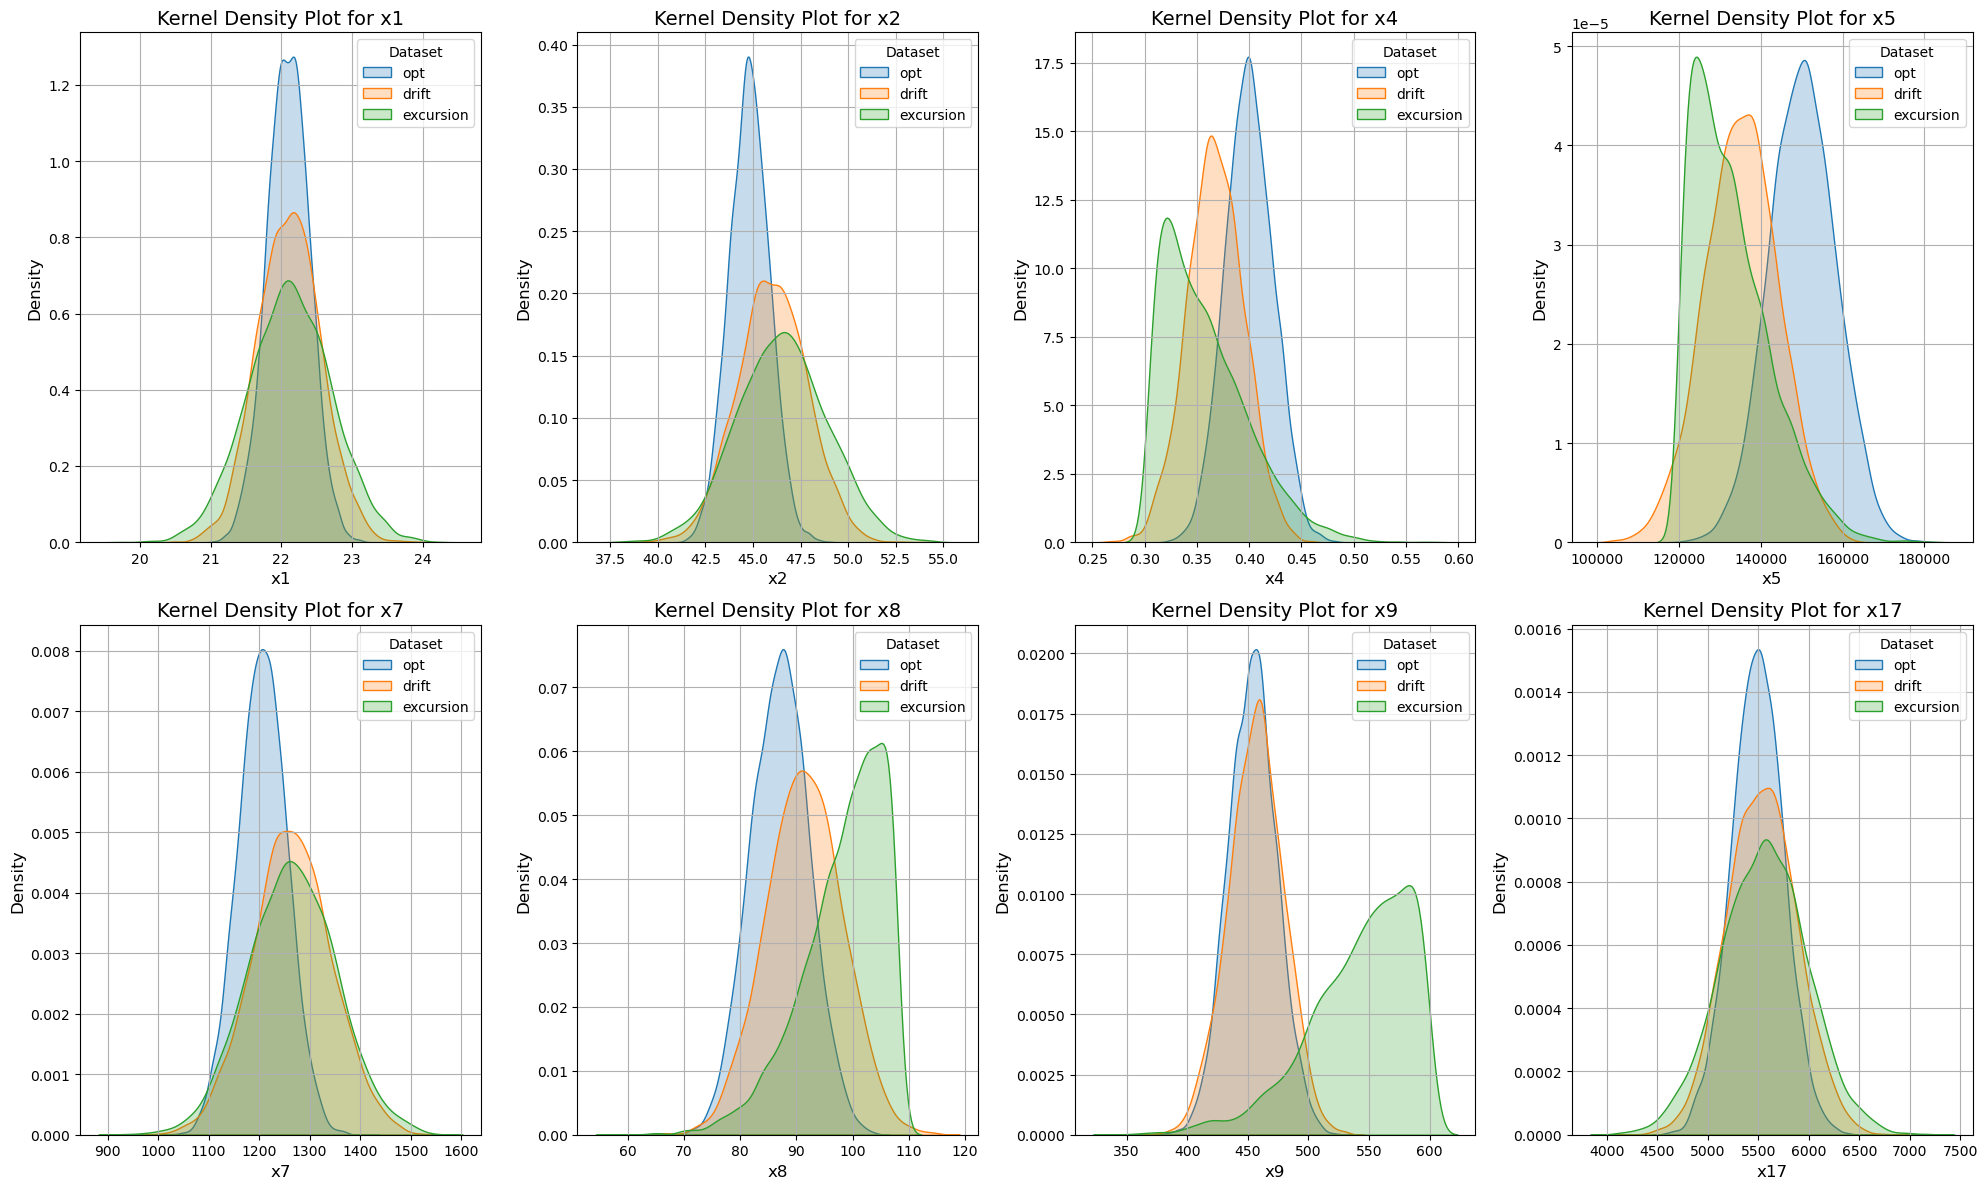

In [18]:
# Define the variables to be plotted
selected_variables = ['x1', 'x2', 'x4', 'x5', 'x7', 'x8', 'x9', 'x17']

# Define the plots per row for the selected variables
plots_per_row = 4
num_variables = len(selected_variables)
num_rows = (num_variables + plots_per_row - 1) // plots_per_row 

# Create the figure for the variable plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, 6 * num_rows))
axes = axes.flatten()  

# Generate the plots for the selected variables
for i, variable in enumerate(selected_variables):
    ax = axes[i]
    for name, df in datasets.items():
        sns.kdeplot(df[variable], label=name, fill=True, ax=ax)
    ax.set_title(f'Kernel Density Plot for {variable}', fontsize=14)
    ax.set_xlabel(variable, fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(title='Dataset')
    ax.grid(True)

# Remove excess subplots if needed
for j in range(len(selected_variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

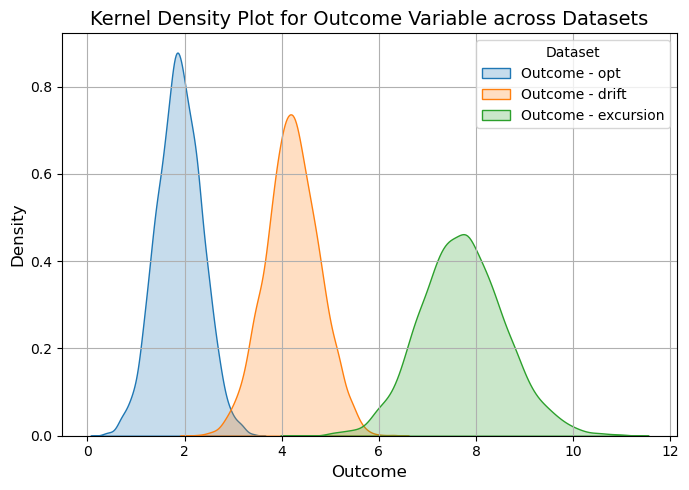

In [21]:
plt.figure(figsize=(7, 5))

# Loop over the datasets and plot the KDE for the 'outcome' variable in each
for name, df in datasets.items():
    sns.kdeplot(df['outcome'], label=f'Outcome - {name}', fill=True)

# Add labels and title
plt.title('Kernel Density Plot for Outcome Variable across Datasets', fontsize=14)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Dataset')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()